### Training a neural network (multi-layer perceptron w/ 1 hidden layers)

아래 코드는 다음 항목을 구현한다.
1. Neural network 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Neural network 모델의 parameter에 대한 gradient 연산
4. 학습된 Neural network 모델 parameter를 적용하여 test data의 classification 결과 도출

In [14]:
# package 불러오기
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

# utility functions

# function: make labels one-hot vectors
def make_labels_onehot(labels, num_cls):
    num_data = labels.shape[0]
    labels_1hot = np.zeros((num_data,num_cls))
    labels_1hot[np.arange(num_data),labels[:]] = 1
    return labels_1hot

# function: visualize sample images
def VisualizeBatchData(batch_data, batch_sz):
    f, axarr = plt.subplots(batch_sz)
    ddim_sq = int(np.sqrt(batch_data[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(batch_sz):
        axarr[i].imshow(batch_data[i][:].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize neuron weight matrix for gradient descent
def VisualizeWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 셀1: 데이터 불러오기

MNIST 데이터셋은 CNN 구조 개발에 큰 공헌을 하면서 Deep learning 분야의 대가로 추앙받는 Yann LeCun 뉴욕대 교수님의 연구로 구축된 영상 데이터셋이다. 
구성 영상은 각각 28x28 크기를 가지며 0부터 9사이의 아라비아 숫자를 필기한 영상으로 각 숫자마다 동일한 수의 영상을 가진다.
총 70000장의 영상 및 레이블들로 구성되며, 각각 60000장으로 구성된 학습 데이터셋과 10000장으로 구성된 테스트 데이터셋으로 나뉜다.

data/MNIST 폴더에 해당 파일들이 이미 저장되어 있는 상태에서 다음 코드를 수행하면 MNIST 데이터셋을 로딩할 수 있다.

In [15]:
def load_mnist_data(data_dir):
    train_images_path = os.path.join(data_dir, 'train-images-idx3-ubyte.gz')
    train_labels_path = os.path.join(data_dir, 'train-labels-idx1-ubyte.gz')
    test_images_path = os.path.join(data_dir, 't10k-images-idx3-ubyte.gz')
    test_labels_path = os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz')

    with gzip.open(train_images_path, 'rb') as f:
        train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(train_labels_path, 'rb') as f:
        train_labels = np.frombuffer(f.read(), np.uint8, offset=8)

    with gzip.open(test_images_path, 'rb') as f:
        test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(test_labels_path, 'rb') as f:
        test_labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return train_images, train_labels, test_images, test_labels

# Specify the directory where the MNIST dataset files are located
data_dir = 'data/MNIST/'  # Replace with the actual directory path

# Load the MNIST dataset
# The training and test data are now available in train_images, train_labels, test_images, and test_labels.
train_images, train_labels, test_images, test_labels = load_mnist_data(data_dir)

num_imgs_tr = train_images.shape[0]
num_imgs_te = test_images.shape[0]
img_sz = train_images.shape[1]
num_cls = 10

##### 셀2: 데이터 전처리

아래 셀에서는 zero-centering 데이터 전처리를 수행한다.

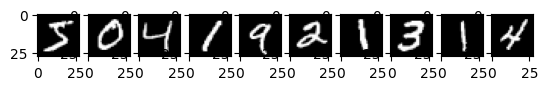

[5 0 4 1 9 2 1 3 1 4]
(60000, 784)
(10000, 784)


In [16]:
# visualize sample images and labels
num_view = 10
f, axarr = plt.subplots(1,num_view) 
for i in range(num_view):
    axarr[i].imshow(train_images[i,:,:],cmap='gray')
plt.show()
print(train_labels[:num_view])

# pre-process sample images
# flatten each image to 1D vector - # 총영상개수x28x28 영상 배열을 총영상개수x28^2 배열로 규격 변경
# **코딩 수행** training data 전처리 
tr_data = train_images.reshape(num_imgs_tr, -1)
print(tr_data.shape)

# **코딩 수행** test data 전처리
te_data = test_images.reshape(num_imgs_te, -1)
print(te_data.shape)

# subtract mean
tr_mean = np.mean(tr_data)
tr_data = tr_data - tr_mean
te_data = te_data - tr_mean

##### 문제3: Neural network 모델의 local gradient 연산 정의

다음 코드는 1개의 hidden layer를 갖는 neural network의 객체를 정의하는 class의 코드이다.

In [186]:
class MLPNeuralNetwork:
    def __init__(self, data_dim, num_hid_neurons, num_cls):
        self.data_dim = data_dim
        self.num_cls = num_cls
        # data_dim <- D in slides, num_cls <- M in slides, num_hid_neurons <- 다양하게 설정하여 실험
        self.W1 = 0.001 * np.random.randn(data_dim, num_hid_neurons)
        self.W2 = 0.001 * np.random.randn(num_hid_neurons, num_cls)
        self.b1 = np.random.randint(num_hid_neurons)
        self.b2 = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls)
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        self.data = data
        
        # 첫번째 hidden layer
        z1 = np.dot(data, self.W1) + self.b1
        a1 = np.maximum(0, z1)
        self.hidden_layer_output = a1
        
        # Output layer
        self.scores = np.dot(a1, self.W2) + self.b2
    
        return self.scores
    def backward(self, upstream_grad, batch_sz):
        # upstream_grad dimensions should be N x M
        # W dimension is D x M
        
        # Output layer gradient 계산
        grad_scores = upstream_grad
        grad_W2 = np.dot(self.hidden_layer_output.T, grad_scores) / batch_sz
        grad_b2 = np.sum(grad_scores, axis=0) / batch_sz
        
        # hidden layer 역전파 계산
        grad_hidden = np.dot(grad_scores, self.W2.T)
        grad_hidden[self.hidden_layer_output <= 0] = 0
        grad_W1 = np.dot(self.data.T, grad_hidden) / batch_sz
        grad_b1 = np.sum(grad_hidden, axis=0) / batch_sz
        
        # W dimension is 1 x M
        
        grad = {'W1':grad_W1, 
                'b1':grad_b1,
                'W2':grad_W2, 
                'b2':grad_b2}
        
        return grad
    def grad_descent(self, grad, lr):
        grad_W1 = grad['W1']
        grad_b1 = grad['b1']
        self.W1 = self.W1 - lr*grad_W1
        self.b1 = self.b1 - lr*grad_b1
        grad_W2 = grad['W2']
        grad_b2 = grad['b2']
        self.W2 = self.W2 - lr*grad_W2
        self.b2 = self.b2 - lr*grad_b2
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W1.shape[0]))
        for j in range(self.num_cls):
            axarr[j].imshow(self.W1[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()


##### 문제4: Softmax loss 함수의 local gradient 연산 정의

다음 코드는 Softmax 함수 기반의 cross-entropy loss 함수와 이를 기준으로 모델을 학습하는데 필요한 gradient를 계산하는 과정을 포함한다.

In [54]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.labels = 0
        self.data = 0
        self.probs = 0
        self.num_cls = num_cls
    def compute_probs(self, data):
        scores = self.model.forward(data)
        self.model_scores = scores
        # compute softmax function
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.probs = softmax_probs
        
        return self.probs    
    def compute_loss(self, data, labels):
        self.data = data
        self.compute_probs(data)
        
        num_samples = data.shape[0]
        correct_class_prob = self.probs[np.arange(num_samples), labels]
        loss = -np.log(correct_class_prob).sum() / num_samples
        self.loss = loss
        
        return self.loss
    def compute_grad(self, labels, batch_sz):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
    
        return self.model.backward(grad_z, batch_sz)


##### 문제5: Gradient descent 알고리즘 구현

다음 코드는 gradient descent 알고리즘으로 학습 데이터에 대해 MLP neural network를 학습하는 코드이다.

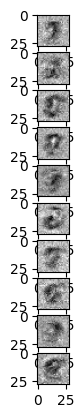

In [200]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    num_samples = db_data.shape[0]
    idxs = np.arange(num_samples)
    np.random.shuffle(idxs)  # 데이터 인덱스를 무작위로 섞음

    batch_data = db_data[idxs[:batch_sz]]  # 미니 배치 데이터 추출
    batch_labels = db_labels[idxs[:batch_sz]]  # 미니 배치 레이블 추출

    # VisualizeBatchData(batch_data,batch_sz)
    return batch_data, batch_labels

def train_mlp_neuralnet(db_data, db_labels, num_cls, lr, batch_sz, num_iter, num_hid_neurons):
    # define & initialize MLP neural network classifier
    num_data = db_data.shape[0]
    data_dim = db_data.shape[1]
    model = MLPNeuralNetwork(data_dim, num_hid_neurons, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        model.data = batch_data
        loss_fn.labels = batch_labels
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        # print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad(batch_labels, batch_sz)
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 2e-4
batch_sz = 256
num_iter = 2000
num_hid_neurons = 128
model = train_mlp_neuralnet(tr_data, train_labels, num_cls, lr, batch_sz, num_iter, num_hid_neurons)

##### 문제6: 학습된 모델을 이용한 test data classification

다음 코드에서는 학습된 MLP neural network를 이용하여 테스트 데이터의 판별 결과를 도출한다.

In [201]:
te_scores = model.forward(te_data)
# 판별 결과를 클래스로 변환 (가장 높은 점수를 갖는 클래스 선택)
te_predictions = np.argmax(te_scores, axis=1)

# 정확도 계산
# 예측값과 실제 레이블이 일치하는 경우 True
correct_predictions = (te_predictions == test_labels) 
# 정확한 예측의 비율 계산 
Acc = np.mean(correct_predictions.astype(float))  

print('Classification accuracy= {}%'.format(Acc*100))

Classification accuracy= 91.5%
